In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from poola import core as pool
import gpplot

In [2]:
path = '/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/Comp Data Sets/Tiling Library/Gilbert 2014/'
seq_detail = pd.read_table(path+"CRISPRicin library 20130912_final_draft_CRISPRicin.txt", header = None)
seq_count = pd.read_table(path + '20230811_counts_files_combined.txt')
seq_count = seq_count[['0', 'dCas9-KRAB ricin LG',  
       'dCas9-KRAB ricin MH', 'dCas9-KRAB untreated MH',
       'dCas9-KRAB untreated LG']]
seq_phenotpye = pd.read_excel(path + 'CRISPRricin compiled all sgRNA data.xlsx', header = None)
new_col_seq_phenotpye = ['guide id'] + seq_phenotpye[[1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,17, 18, 19, 20, 21, 22, 23, 24]][0:3].apply('_'.join,  axis=0).tolist()
seq_phenotpye = seq_phenotpye.drop([0, 1,2,3], axis=0)
seq_phenotpye.columns = new_col_seq_phenotpye

/Users/fzheng/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
#second pass on cleaning Gilbert dataset using first pass as the input: this had furthered cleaned but dont have guide id
# so using the first pass to find the context sequence using guide id and then use the second pass to keep the nesscary context seq
outpath = '/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/data/2024/Manuscript/CleanedData/'
NewDatasetCombine = pd.read_csv(outpath + 'DatasetCombineCleaned_v2.csv', low_memory=False)
NewDatasetGilbert = NewDatasetCombine[NewDatasetCombine.DataSet == 'Gilbert']

In [4]:
# use count to calcuate LFC: remove T0 with z-score less than -3
lognorms_tiling = pool.lognorm_columns(reads_df=seq_count, columns=['dCas9-KRAB ricin LG', 'dCas9-KRAB ricin MH', 
                                                                          'dCas9-KRAB untreated MH','dCas9-KRAB untreated LG'])
filtered_lognorms_tiling = pool.filter_pdna(lognorm_df=lognorms_tiling, 
                                                  pdna_cols=['dCas9-KRAB untreated MH','dCas9-KRAB untreated LG'], z_low=-3)
print('Filtered ' + str(lognorms_tiling.shape[0] - filtered_lognorms_tiling.shape[0]) + ' rows due to low pDNA abundance')


Filtered 1092 rows due to low pDNA abundance


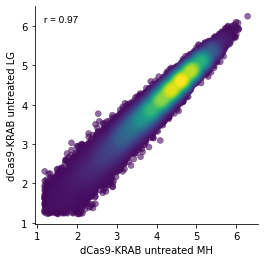

In [5]:
# use count to calcuate LFC: check lognorms of T0 repeats correlation 
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=filtered_lognorms_tiling, x='dCas9-KRAB untreated MH', y='dCas9-KRAB untreated LG')
gpplot.add_correlation(data=filtered_lognorms_tiling, x='dCas9-KRAB untreated MH', y='dCas9-KRAB untreated LG')
sns.despine()

In [6]:
# use count to calcuate LFC: find average lognorms of T0 because they corrlate well
filtered_lognorms_tiling['avgCountsUntreated'] = filtered_lognorms_tiling[['dCas9-KRAB untreated MH', 'dCas9-KRAB untreated LG']].mean(axis=1)



In [7]:
# use count to calcuate LFC: calcuate LFC relative to the averaged T0 lognmorm 
lfc_tiling = pool.calculate_lfcs(lognorm_df=filtered_lognorms_tiling, 
                                         ref_col='avgCountsUntreated', 
                                       target_cols=['dCas9-KRAB ricin LG', 'dCas9-KRAB ricin MH'])
lfc_tiling = lfc_tiling[['0', 'dCas9-KRAB ricin LG', 'dCas9-KRAB ricin MH']]
lfc_tiling.head()


,0,dCas9-KRAB ricin LG,dCas9-KRAB ricin MH
0,ARCN1_c_118438373.25,-0.914327,-0.945535
1,ARCN1_c_118438478.24,-0.200292,-0.195294
2,ARCN1_c_118438478.26,0.434630,-0.004084
3,ARCN1_c_118438508.26,0.108739,-0.563859
4,ARCN1_c_118438682.27,-0.651167,-0.009016


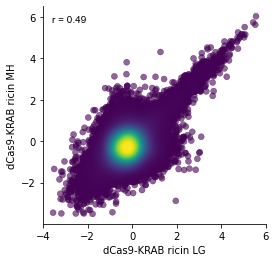

In [8]:
#remove nas
lfc_tiling = lfc_tiling.dropna()
#  check LFC of Tfinal repeats correlation 
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_tiling, x='dCas9-KRAB ricin LG', y='dCas9-KRAB ricin MH')
gpplot.add_correlation(data=lfc_tiling, x='dCas9-KRAB ricin LG', y='dCas9-KRAB ricin MH')
sns.despine()

In [9]:
# find average LFC of Tfinal because they corrlate moderately
lfc_tiling['Avg_LFC'] = lfc_tiling[['dCas9-KRAB ricin LG', 'dCas9-KRAB ricin MH']].mean(axis=1)


In [10]:
# add orginal phenotyp
lfc_tiling = pd.merge(seq_phenotpye[['guide id','dCas9-KRAB_rho_ave_LG2_LG_MH2_MH']],
         lfc_tiling.rename(columns = {'0': 'guide id'}))
lfc_tiling["dCas9-KRAB_rho_ave_LG2_LG_MH2_MH"] = lfc_tiling["dCas9-KRAB_rho_ave_LG2_LG_MH2_MH"].astype(float)
len(lfc_tiling)

54403

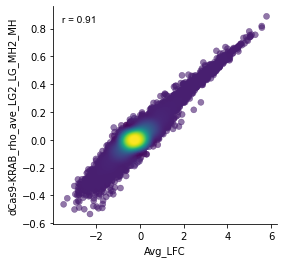

In [11]:
#  check LFC of Tfinal repeats correlation 
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_tiling, x='Avg_LFC', y='dCas9-KRAB_rho_ave_LG2_LG_MH2_MH')
gpplot.add_correlation(data=lfc_tiling, x='Avg_LFC', y='dCas9-KRAB_rho_ave_LG2_LG_MH2_MH' )
sns.despine()

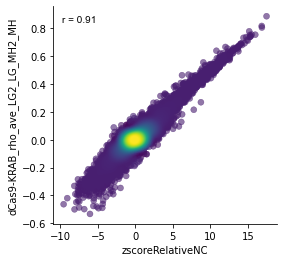

In [12]:
# calcuate z-score relative to neg control
nc_mean = lfc_tiling[lfc_tiling['guide id'].str[:3] == "neg"]['Avg_LFC'].mean()
nc_mean_std = lfc_tiling[lfc_tiling['guide id'].str[:3] == "neg"]['Avg_LFC'].std()
lfc_tiling['zscoreRelativeNC'] = (lfc_tiling['Avg_LFC'] - nc_mean)/nc_mean_std

#  check orginal phenotype vs zscore for all 54403 guide
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_tiling, x='zscoreRelativeNC', y='dCas9-KRAB_rho_ave_LG2_LG_MH2_MH')
gpplot.add_correlation(data=lfc_tiling, x='zscoreRelativeNC', y='dCas9-KRAB_rho_ave_LG2_LG_MH2_MH' )
sns.despine()

In [13]:
len(lfc_tiling)

54403

In [14]:
# first pass on cleaning Gilbert dataset still maintaining the guide id
outpath1 = '/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/data/2023/cleaned_crispri_datasets/'
cleaned_df_no_dup = pd.read_csv(outpath1 + 'gilbert_2014_cleaned_v3.csv')
len(cleaned_df_no_dup)

24905

In [15]:
lfc_tiling = pd.merge(cleaned_df_no_dup[['guide id', 'sgRNA sequence','context seq']],
        lfc_tiling[['guide id','dCas9-KRAB_rho_ave_LG2_LG_MH2_MH','Avg_LFC','zscoreRelativeNC']])

In [16]:
#second pass on cleaning Gilbert dataset using first pass as the input: this had furthered cleaned but dont have guide id
# so using the first pass to find the context sequence using guide id and then use the second pass to keep the nesscary context seq
outpath = '/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/data/2024/Manuscript/CleanedData/'
NewDatasetCombine = pd.read_csv(outpath + 'DatasetCombineCleaned_v2.csv', low_memory=False)
NewDatasetGilbert = NewDatasetCombine[NewDatasetCombine.DataSet == 'Gilbert']

In [17]:
len(NewDatasetGilbert)

18595

In [18]:
lfc_tiling = pd.merge(NewDatasetGilbert[['Target Gene Symbol', 'chromosome', 'sgRNA Sequence',
       'sgRNA Context Sequence', 'sgRNA \'Cut\' Position', 'Strand of Target',
       'TSS Position', 'sgRNA \'Cut\' Site TSS Offset', 'orginal phenotype']],
        lfc_tiling.rename(columns = {'sgRNA sequence':'sgRNA Sequence', 
                                     'context seq': 'sgRNA Context Sequence'}))
len(lfc_tiling)


18458

In [19]:
# understand Resistance and Susceptibility gene behavior
resin_gene = pd.read_csv('/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Laura/2023/TSS Annotations /Data/CRISPRricin compiled all sgRNA data with phenotype-signed z scores.csv') #= pd.read_csv('/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Laura/TSS Annotations /Data/CRISPRricin compiled all sgRNA data with phenotype-signed z scores.csv')
resin_gene = resin_gene[['gene','Target Gene Function']].drop_duplicates()
gilbertResinGeneBehaviorAvg = pd.DataFrame(lfc_tiling.groupby('Target Gene Symbol')['dCas9-KRAB_rho_ave_LG2_LG_MH2_MH'].mean()).reset_index()
summaryGilbertResinBehavior = pd.merge(gilbertResinGeneBehaviorAvg, resin_gene, right_on = 'gene', left_on = 'Target Gene Symbol')
summaryGilbertResinBehavior

,Target Gene Symbol,dCas9-KRAB_rho_ave_LG2_LG_MH2_MH,gene,Target Gene Function
0,ARF1,0.009342,ARF1,Susceptibility
1,ARL1,-0.064224,ARL1,Resistance
2,CARM1,0.011212,CARM1,Susceptibility
3,COG1,-0.009737,COG1,Resistance
4,COG3,-0.059005,COG3,Resistance
5,COPB1,-0.027128,COPB1,Resistance
6,CREBBP,-0.013314,CREBBP,Resistance
7,EIF6,-0.028752,EIF6,Resistance
8,GBF1,0.019498,GBF1,Susceptibility
9,GOLGA1,0.048380,GOLGA1,Susceptibility


In [20]:
GilbertRicinCleanData = pd.merge(lfc_tiling, 
                                 resin_gene.rename(columns={'gene':'Target Gene Symbol'}),
                                 on = 'Target Gene Symbol')

GilbertRicinCleanData.loc[:,"phenotype-signed rho"]=GilbertRicinCleanData.apply(
    lambda r:(r.loc["dCas9-KRAB_rho_ave_LG2_LG_MH2_MH"]*(-1)) if r.loc["Target Gene Function"]=="Resistance" \
              else (r.loc["dCas9-KRAB_rho_ave_LG2_LG_MH2_MH"]), axis=1)
len(GilbertRicinCleanData)

18458

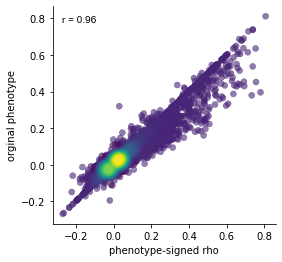

In [21]:
plt.subplots(figsize=(4,4))
# phenotype-signed rho: reported phenotype with sign change
# orginal phenotype: reported phenotype with sign change and average across common context sequence

gpplot.point_densityplot(data=GilbertRicinCleanData, x='phenotype-signed rho', y='orginal phenotype')
gpplot.add_correlation(data=GilbertRicinCleanData, x='phenotype-signed rho', y='orginal phenotype')
sns.despine()

# the correlation is not 1 because in 00_gilbert_2014_cleaning i took the average of context seq

In [22]:
GilbertRicinCleanData[GilbertRicinCleanData['phenotype-signed rho']>0.74]

,Target Gene Symbol,chromosome,sgRNA Sequence,sgRNA Context Sequence,sgRNA 'Cut' Position,Strand of Target,TSS Position,sgRNA 'Cut' Site TSS Offset,orginal phenotype,guide id,dCas9-KRAB_rho_ave_LG2_LG_MH2_MH,Avg_LFC,zscoreRelativeNC,Target Gene Function,phenotype-signed rho
8603,QSOX2,chr9,GGTGAAACGGAGCCACCCCT,GCTCGGTGAAACGGAGCCACCCCTGGGACC,136247964.0,-,136245812.0,-2151.0,0.395882,QSOX2_c_139139815.23,0.779203,4.998427,15.188330,Susceptibility,0.779203
13199,SEC23B,chr20,GAGCTGAGCTGGACTTGGCGG,TGAGAGCTGAGCTGGACTTGGCGGTGGGAG,18507918.0,+,18507941.0,-23.0,0.635924,SEC23B_c_18488567.24,0.753233,5.028688,15.276390,Susceptibility,0.753233
13203,SEC23B,chr20,GAGCCTGCTTGTTGCAGCTGT,CCGGAGCCTGCTTGTTGCAGCTGTGGGTGA,18507948.0,+,18507941.0,7.0,0.812056,SEC23B_c_18488597.24,0.806408,5.579808,16.880138,Susceptibility,0.806408
13227,SEC23B,chr20,GCGAGGTGAGCGGCTTCTGGG,GGGGCGAGGTGAGCGGCTTCTGGGAGGAGG,18508068.0,+,18507941.0,127.0,0.452199,SEC23B_c_18488717.24,0.755565,5.109605,15.511858,Susceptibility,0.755565


In [23]:
GilbertRicinCleanData = GilbertRicinCleanData[['Target Gene Symbol', 'chromosome', 'sgRNA Sequence',
       'sgRNA Context Sequence', 'sgRNA \'Cut\' Position','Strand of Target', 'TSS Position', 'sgRNA \'Cut\' Site TSS Offset', 'orginal phenotype', 'Avg_LFC',
       'zscoreRelativeNC', 'Target Gene Function']]
GilbertRicinCleanData = GilbertRicinCleanData.rename(columns={'orginal phenotype': 'rhoSignChangedAndAvged'})

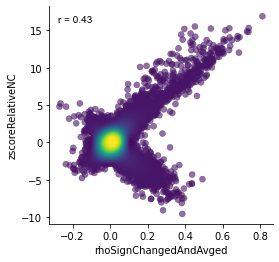

In [24]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=GilbertRicinCleanData, x='rhoSignChangedAndAvged', y='zscoreRelativeNC')
gpplot.add_correlation(data=GilbertRicinCleanData, x='rhoSignChangedAndAvged', y='zscoreRelativeNC')
sns.despine()

In [25]:
GilbertRicinCleanData.loc[:,"zscoreRelativeNC_signed"]=GilbertRicinCleanData.apply(
    lambda r:(r.loc["zscoreRelativeNC"]*(-1)) if r.loc["Target Gene Function"]=="Resistance" \
              else (r.loc["zscoreRelativeNC"]), axis=1)

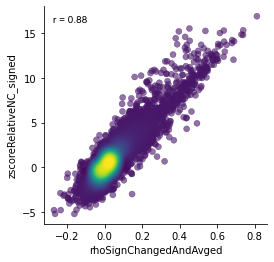

In [26]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=GilbertRicinCleanData, x='rhoSignChangedAndAvged', y='zscoreRelativeNC_signed')
gpplot.add_correlation(data=GilbertRicinCleanData, x='rhoSignChangedAndAvged', y='zscoreRelativeNC_signed')
sns.despine()
# for only the cleaned guide

In [29]:
GilbertRicinCleanData = GilbertRicinCleanData[GilbertRicinCleanData['sgRNA \'Cut\' Site TSS Offset'] <=5000]

In [30]:
len(GilbertRicinCleanData)

18458

In [31]:
GilbertRicinCleanData.to_csv('/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/data/2024/Manuscript/Gilbert/Gilbert2014Cleaned2024.csv',
                    index = False)